# Imports

In [1]:
import numpy as np
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import argparse
from torchvision import models, transforms
from torch.nn import functional as F
from torch import topk

# Define image transformations

In [2]:
# define the transforms, resize => tensor => normalize
transforms = transforms.Compose(
    [transforms.ToPILImage(),
     transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
    ])

# Load RESNET-18

In [3]:
# load the model
model = models.resnet18(pretrained=True).eval()

# hook the feature extractor
features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())
model._modules.get('layer4').register_forward_hook(hook_feature)

# get the softmax weight
params = list(model.parameters())
weight_softmax = np.squeeze(params[-2].data.numpy())

C:\Users\edvin\anaconda3\envs\deepimg\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\edvin\anaconda3\envs\deepimg\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Load labels

In [4]:
def load_synset_classes(file_path):
    # load the synset text file for labels
    all_classes = []
    with open(file_path, 'r') as f:
        for line in f.readlines():
            label = line.strip().split(':', 1)[1].strip(" '").split(',')[0]
            label = label.strip("'")  # Remove any remaining single quotes
            all_classes.append(label)
    return all_classes

# get all the classes in a list
all_classes = load_synset_classes('labels.txt')

# CAM functions

In [5]:
def returnCAM(feature_conv, weight_softmax, class_idx):
    """
    generate the class activation maps upsample to 256x256
    
    feature_conv.shape = 1x512x7x7
    weight_softmax.shape = 1000x512
    
    weight_softmax[0].shape = 1x512
    feature_conv.reshape((nc, h*w)).shape = 512x49
    """
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
        
    # weighted sum of all feature maps
    cam = weight_softmax[class_idx].dot(feature_conv.reshape((nc, h*w))) # cam.shape = 1x49
    cam = cam.reshape(h, w) # cam.shape = 7x7

    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    cam_img = np.uint8(255 * cam_img)

    output_cam = cv2.resize(cam_img, size_upsample) # output_cam.shape = 256x256
        
    return output_cam

In [6]:
def transform_and_forward(image, transforms,model):
    # apply the image transforms
    image_tensor = transforms(image).unsqueeze(0)

    # forward pass through model
    outputs = model(image_tensor)

    # get the softmax probabilities
    probs = F.softmax(outputs, dim=1).data.squeeze()

    # get the class indices of top k probabilities
    class_idx = topk(probs, 1)[1].int()
    
    return class_idx, probs

In [7]:
def show_cam(CAM, width, height, orig_image, class_idx, all_classes, save_name):
        heatmap = cv2.applyColorMap(cv2.resize(CAM,(width, height)), cv2.COLORMAP_JET)
        result = heatmap * 0.3 + orig_image * 0.5
        
        # put class label text on the result
        result = cv2.putText(result, all_classes[class_idx], (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 0), 2)
        result = result.astype(np.float32) # Cast to float32
        result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB) # Convert to RGB
        
        # Plot image
        plt.imshow(result/255.)
       
        # Settings
        plt.axis('off')
        plt.show()
        
        # Save output
        cv2.imwrite(f"outputs/output_{save_name}", result)
        features_blobs.clear()

In [10]:
def get_CAM_overlay(CAM, width, height, orig_image, class_idx, all_classes):
    heatmap = cv2.applyColorMap(cv2.resize(CAM,(width, height)), cv2.COLORMAP_JET)
    result = heatmap * 0.3 + orig_image * 0.5

    # put class label text on the result
    result = cv2.putText(result, all_classes[class_idx], (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 0), 2)
    result = result.astype(np.float32) # Cast to float32
    result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB) # Convert to RGB
    result = result/255

    # Clear for next image
    features_blobs.clear()
    
    return result

# Load images

Available classes can be found: https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a

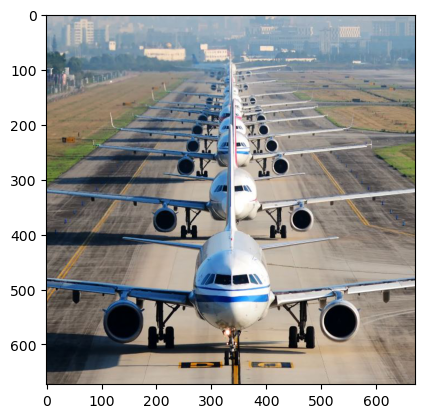

In [60]:
input_file = "airplane2.jpg"

image = cv2.imread(input_file)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
height, width, _ = image.shape

imshow(image)

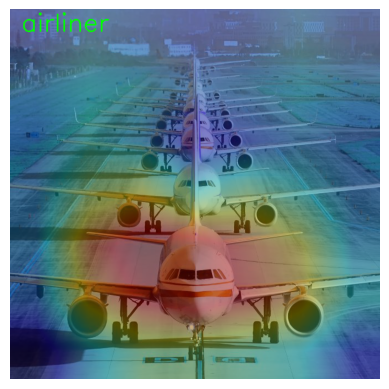

In [61]:
# Feed image
class_idx, probs = transform_and_forward(image,transforms,model)

# generate class activation mapping for the top1 prediction
CAMs = returnCAM(features_blobs[0], weight_softmax, class_idx)

# show and save the results
show_cam(CAMs, width, height, image, class_idx, all_classes, input_file)

# Variations

### Flip

In [62]:
flipped_image = cv2.flip(image, 1)

### Noise

In [63]:
def add_noise(image, mean=0, stddev=30):
    h, w, c = image.shape
    noise = np.random.normal(mean, stddev, (h, w, c)).astype(np.float32)
    noisy_image = image.astype(np.float32) + noise
    noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)
    return noisy_image

noisy_image = add_noise(image,0,100)

### Contrast

In [64]:
contrast_image = cv2.convertScaleAbs(image, alpha=1.5, beta=0)

### Show result

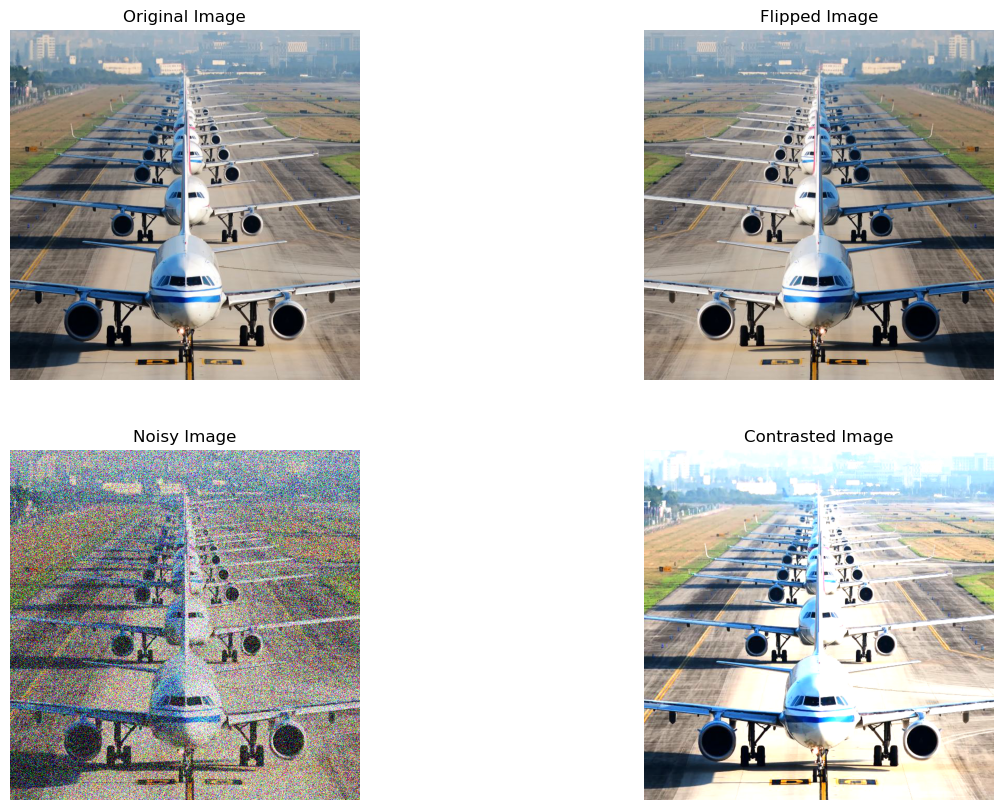

In [65]:
# Display the images in a 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Display the original image
axs[0,0].imshow(image)
axs[0,0].set_title('Original Image')
axs[0,0].axis('off')

# Display the flipped and noisy image
axs[0,1].imshow(flipped_image)
axs[0,1].set_title('Flipped Image')
axs[0,1].axis('off')

# Display the noisy image
axs[1,0].imshow(noisy_image)
axs[1,0].set_title('Noisy Image')
axs[1,0].axis('off')

# Display the enhanced image
axs[1,1].imshow(contrast_image)
axs[1,1].set_title('Contrasted Image')
axs[1,1].axis('off')

# Show the grid of images
plt.savefig("outputs/variations.jpg")
plt.show()

# Apply CAM to variations

### Original

In [66]:
class_idx, probs = transform_and_forward(image,transforms,model)

CAMs = returnCAM(features_blobs[0], weight_softmax, class_idx) # generate class activation mapping for the top1 prediction

top_probs, top_indices = topk(probs, 5)
top_class_names = [all_classes[idx] for idx in top_indices]
print("Top 5 class names:", top_class_names)

image_cam = get_CAM_overlay(CAMs, width, height, image, class_idx, all_classes) # show and save the results

Top 5 class names: ['airliner', 'wing', 'aircraft carrier', 'warplane', 'submarine']


### Flipped

In [67]:
class_idx, probs = transform_and_forward(flipped_image,transforms,model)

CAM = returnCAM(features_blobs[0], weight_softmax, class_idx) # generate class activation mapping for the top1 prediction

top_probs, top_indices = topk(probs, 5)
top_class_names = [all_classes[idx] for idx in top_indices]
print("Top 5 class names:", top_class_names)

flipped_cam = get_CAM_overlay(CAM, width, height, flipped_image, class_idx, all_classes) # show and save the results

Top 5 class names: ['airliner', 'wing', 'warplane', 'aircraft carrier', 'submarine']


### Noisy

In [68]:
class_idx, probs = transform_and_forward(noisy_image,transforms,model)

CAM = returnCAM(features_blobs[0], weight_softmax, class_idx) # generate class activation mapping for the top1 prediction

top_probs, top_indices = topk(probs, 5)
top_class_names = [all_classes[idx] for idx in top_indices]
print("Top 5 class names:", top_class_names)

noisy_cam = get_CAM_overlay(CAM, width, height, noisy_image, class_idx, all_classes) # show and save the results

Top 5 class names: ['airliner', 'wing', 'aircraft carrier', 'submarine', 'cannon']


### Contrast

In [69]:
class_idx, probs = transform_and_forward(contrast_image,transforms,model)

CAM = returnCAM(features_blobs[0], weight_softmax, class_idx) # generate class activation mapping for the top1 prediction

top_probs, top_indices = topk(probs, 5)
top_class_names = [all_classes[idx] for idx in top_indices]
print("Top 5 class names:", top_class_names)

contrast_cam = get_CAM_overlay(CAM, width, height, contrast_image, class_idx, all_classes) # show and save the results

Top 5 class names: ['airliner', 'wing', 'aircraft carrier', 'racer', 'warplane']


# Print variations with CAM

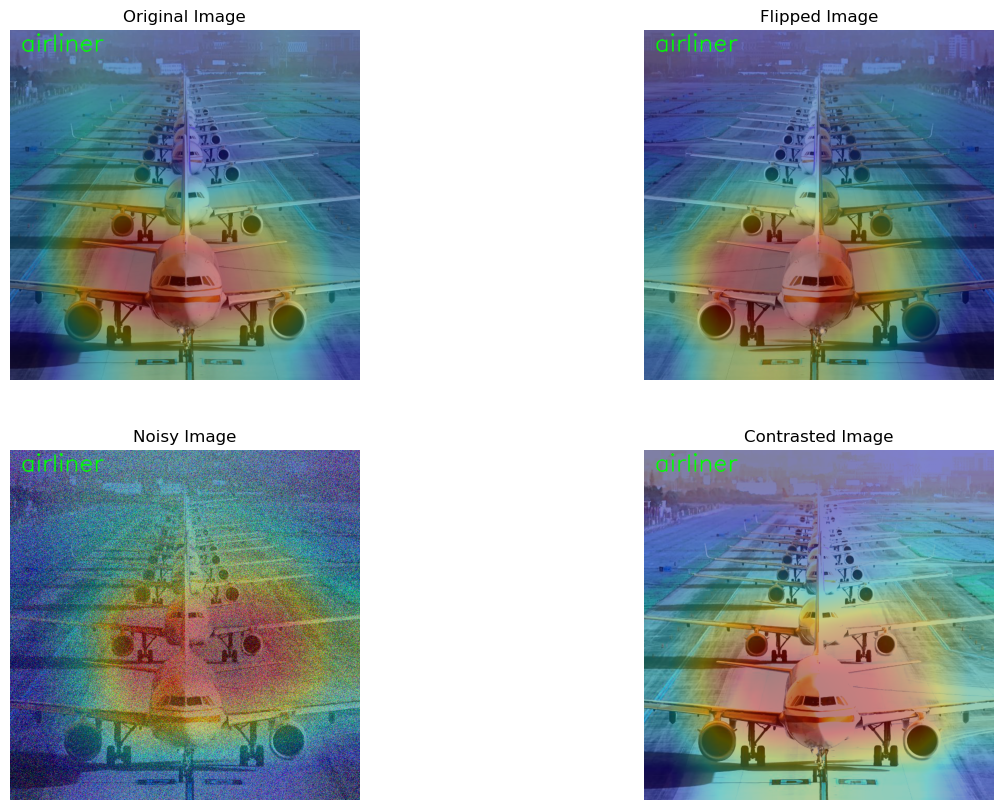

In [70]:
# Display the images in a 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Display the original image
axs[0,0].imshow(image_cam)
axs[0,0].set_title('Original Image')
axs[0,0].axis('off')

# Display the flipped and noisy image
axs[0,1].imshow(flipped_cam)
axs[0,1].set_title('Flipped Image')
axs[0,1].axis('off')

# Display the noisy image
axs[1,0].imshow(noisy_cam)
axs[1,0].set_title('Noisy Image')
axs[1,0].axis('off')

# Display the enhanced image
axs[1,1].imshow(contrast_cam)
axs[1,1].set_title('Contrasted Image')
axs[1,1].axis('off')

# Show the grid of images
plt.savefig("outputs/variations_cam.jpg")
plt.show()